In [3]:
import numpy as np
import pandas as pd
import os
import shutil
import tarfile
import matplotlib
import matplotlib.pyplot as plt
import keras as keras
from data_utils import read_files
import platform
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [4]:
if platform.system() == 'Darwin':
    datafile_path = '/Users/anjalikarimpil/Google Drive/Dissertation/Data/Social LSTM/'
else:
    datafile_path = '/users/mscdsa2018/ask2/Projects/Data/Social LSTM'
# Get list of datafiles read
df_list, problem_list = read_files()


In [5]:
df = df_list[0].copy()
df['date'], df['time'] = df[0].str.split('T', 1).str
df[0] = pd.to_datetime(df[0], format="%Y-%m-%dT%H:%M:%S:%f")
df.columns = ['datetime', 'place', 'x_pos', 'y_pos', 'person_id', 'date', 'time']

In [6]:
df.sort_values(['person_id','datetime'], inplace=True, ascending=True)
df.reset_index()
df['time_lag'] = df.groupby(['person_id', 'date'])['datetime'].shift(1)
df['person_lag'] = df['person_id'].shift(1)


TIME_THRESHOLD = pd.to_timedelta('00:00:02.00000')
# flag 1 
df['fl_1'] = (abs(df['time_lag'] - df['datetime']) > TIME_THRESHOLD) | (df['person_lag'] != df['person_id'])
df['traj_id'] = df['fl_1'].cumsum()


In [7]:
POSITION_THRESHOLD = 500
df['x_lag'] = df.groupby(['traj_id'])['x_pos'].shift(1)
df['y_lag'] = df.groupby(['traj_id'])['y_pos'].shift(1)

df['x_diff'] = abs(df['x_pos'] - df['x_lag'])
df['y_diff'] = abs(df['y_pos'] - df['y_lag'])
df['fl_2'] = (df['x_diff'] > POSITION_THRESHOLD) | (df['y_diff'] > POSITION_THRESHOLD)
df['fl_3'] = (df['fl_1'] | df['fl_2'])
df['traj_id'] = df['fl_3'].cumsum()

In [8]:
df['x_lag'] = df.groupby(['traj_id'])['x_pos'].shift(1)
df['y_lag'] = df.groupby(['traj_id'])['y_pos'].shift(1)

df['x_diff'] = abs(df['x_pos'] - df['x_lag'])
df['y_diff'] = abs(df['y_pos'] - df['y_lag'])



count   498.00
mean     81.42
std      56.63
min       0.00
25%      44.00
50%      70.00
75%     120.00
max     262.00
Name: x_diff, dtype: float64

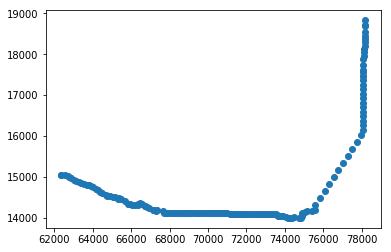

In [14]:
index = 6
df_1 = df.loc[df['traj_id'] == index]
plt.scatter(df_1['x_pos'], df_1['y_pos'])
plt.show()

In [32]:
data = df[['traj_id','x_pos','y_pos']].copy()
INPUT_SEQ_LENGTH = 5
OUTPUT_SEQ_LENGTH = 2
NUM_DIMENSIONS = 2
for i in range(1, INPUT_SEQ_LENGTH + OUTPUT_SEQ_LENGTH):
    data['x_' + str(i)] = data.groupby(['traj_id'])['x_pos'].shift(-i)
    data['y_' + str(i)] = data.groupby(['traj_id'])['y_pos'].shift(-i)
# Remove NAs 
data = data.dropna()

In [9]:
from sklearn.model_selection import train_test_split
def dataset_generator(data):
    train = 0.8
    test = 0.2
#     dev = 0.1
    total_length = len(data)
    total_trajectories = np.ma.count(data['traj_id'].unique())
    train_ix = train * total_trajectories
    test_ix = test * total_trajectories
    X = data.iloc[:, 1:(INPUT_SEQ_LENGTH * NUM_DIMENSIONS)]
    Y = data.iloc[:, -(OUTPUT_SEQ_LENGTH * NUM_DIMENSIONS):]
    X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                        train_size = 0.8, test_size = 0.2, random_state = 1)
    return X_train, X_test, y_train, y_test
#     dev_ix = dev * total_trajectories


In [ ]:
X_train, X_test, y_train, y_test = dataset_generator(data)

In [12]:
pedestrian_data = data_utils.get_pedestrian_data()

[     traj_id  x_pos  y_pos      x_1      y_1      x_2      y_2      x_3  \
 105        1  74276  14165 74034.00 14228.00 73904.00 14152.00 73886.00   
 360        2  42768  15017 42699.00 15030.00 42630.00 15044.00 42561.00   
 490        2  36849  21373 36853.00 21491.00 36848.00 21608.00 36852.00   
 173        1  65829  13889 65656.00 13938.00 65552.00 13961.00 65416.00   
 194        2  61239  14064 61083.00 14071.00 60952.00 14047.00 60830.00   
 67         1  77370  15761 77298.00 15719.00 77227.00 15678.00 77155.00   
 70         1  77155  15636 77084.00 15595.00 77012.00 15553.00 76941.00   
 438        2  37370  16071 37326.00 16119.00 37326.00 16229.00 37326.00   
 177        1  65225  14022 65028.00 14046.00 64941.00 14058.00 64760.00   
 396        2  40277  15503 40207.00 15517.00 40138.00 15530.00 40069.00   
 358        2  42907  14990 42837.00 15003.00 42768.00 15017.00 42699.00   
 198        2  60701  14046 60586.00 14041.00 60470.00 14063.00 60272.00   
 31         

In [36]:
X_train = X_train.reshape((-1, 2, w) )
X_test = X_test.reshape((-1, 2, w) )

In [2]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
w = 5

(3460780, 2, 5) (432598, 2, 5) (3460780, 2) (432598, 2)


In [3]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
import numpy as np


print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(2, w)))
model.add(Dense(2))

# try using different optimizers and different optimizer configs
model.compile(loss='mae',
              optimizer='adam',
              metrics=['accuracy'])



/users/mscdsa2018/ask2/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Build model...


In [4]:

print('Train...')
history = model.fit(X_train,y_train,epochs=25, batch_size = 64, validation_data=(X_test, y_test))

model.save('my_model.h5')

score = model.evaluate(X_test, y_test, batch_size=64)
print(score)

print('Predicting')
# predicted_output = model.predict(test_input, batch_size=72)

Train...
Train on 3460780 samples, validate on 432598 samples
Epoch 1/25
3460780/3460780 [==============================] - 191s 55us/step - loss: 30860.3289 - acc: 0.2853 - val_loss: 29352.4973 - val_acc: 0.1689
Epoch 2/25
3460780/3460780 [==============================] - 191s 55us/step - loss: 27763.9874 - acc: 0.1691 - val_loss: 26368.1039 - val_acc: 0.1689
Epoch 3/25
3460780/3460780 [==============================] - 191s 55us/step - loss: 24728.7902 - acc: 0.2913 - val_loss: 23164.8745 - val_acc: 0.1692
Epoch 4/25
3460780/3460780 [==============================] - 190s 55us/step - loss: 21722.6004 - acc: 0.5221 - val_loss: 20697.6800 - val_acc: 0.8311
Epoch 5/25
3460780/3460780 [==============================] - 190s 55us/step - loss: 19459.2739 - acc: 0.8309 - val_loss: 18726.0717 - val_acc: 0.8311
Epoch 6/25
3460780/3460780 [==============================] - 190s 55us/step - loss: 18220.8393 - acc: 0.8309 - val_loss: 17700.7415 - val_acc: 0.8311
Epoch 7/25
3460780/3460780 [====

In [5]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               68608     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 68,866
Trainable params: 68,866
Non-trainable params: 0
_________________________________________________________________
None


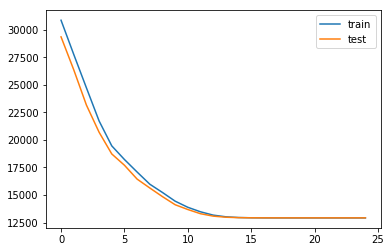

In [8]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

In [9]:
model.summary()
print("Inputs: {}".format(model.input_shape))
print("Outputs: {}".format(model.output_shape))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               68608     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 68,866
Trainable params: 68,866
Non-trainable params: 0
_________________________________________________________________
Inputs: (None, 2, 5)
Outputs: (None, 2)


In [43]:
model = keras.models.load_model('my_model.h5')

In [10]:
y_hat_test = model.predict(X_test)

In [11]:
y_hat_test.shape

(432598, 2)

In [12]:

dist = np.linalg.norm(y_hat_test-y_test, axis=1)

In [13]:

print(1/len(dist)*(np.sum(dist)))


22346.765945448784


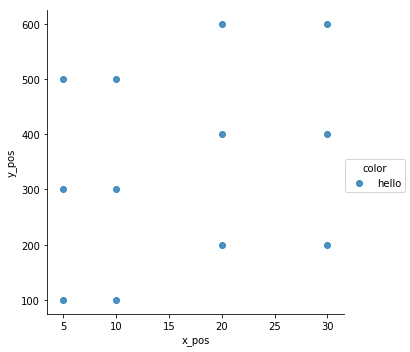

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

x_pos = [5, 10, 20, 30, 5, 10, 20, 30, 5, 10, 20, 30]
y_pos = [100, 100, 200, 200, 300, 300, 400, 400, 500, 500, 600, 600]
color =['D', 'D', 'D', 'E', 'E', 'E', 'F', 'F', 'F', 'G', 'G', 'G',]

df = pd.DataFrame(dict(x_pos=x_pos, y_pos=y_pos, color=color))

sns.lmplot('x_pos', 'y_pos', data=df, hue='color', fit_reg=False)

plt.show()


In [6]:
dict(carat=carat, price=price, color=color)

{'carat': [5, 10, 20, 30, 5, 10, 20, 30, 5, 10, 20, 30],
 'color': ['D', 'D', 'D', 'E', 'E', 'E', 'F', 'F', 'F', 'G', 'G', 'G'],
 'price': [100, 100, 200, 200, 300, 300, 400, 400, 500, 500, 600, 600]}

In [4]:
from visualise import show_pedestrian_path
import config
import pandas as pd
data = pd.read_csv('GRU_test_prediction_and_real.csv', header=None)
data.head(5)


,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,37326.0,37326.0,37326.0,37326.0,37326.0,37326.0,37326.0,37326.0,18099.0,18209.0,...,37326.0,18978.0,19088.0,19198.0,38529.919163,38517.683592,38516.627882,18981.928663,18895.051829,18885.107728
1,78293.0,78316.0,78337.0,78338.0,78356.0,78363.0,78378.0,78404.0,20763.0,20728.0,...,78383.0,20263.0,20203.0,20146.0,81064.276830,81030.133394,80984.370527,20221.783799,20009.923887,19859.557658
2,48511.0,48249.0,48175.0,48042.0,47841.0,47916.0,47798.0,47642.0,14409.0,14286.0,...,47397.0,14217.0,14249.0,14263.0,49045.817374,48928.447407,48838.122501,14247.050147,14211.500078,14285.980381


3